<a href="https://colab.research.google.com/github/wingated/cs473/blob/main/labs/cs473_lab_week_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><p><b>After clicking the "Open in Colab" link, copy the notebook to your own Google Drive before getting started, or it will not save your work</b></p>

# BYU CS 473 Lab Week 8

## Introduction:

For this lab, you will be using Deep Metric Learning on a face recognition dataset using a few different types of loss. Much of the boilerplate code has been done for you, and you will be focusing on implementing Contrastive Loss and Triplet Loss as described in the book (Section 16.2.4, pg. 555) and evaluating the results of your trained models relative to each other and to the base model. We've given you some freedom on how you do the evaluation of the results, and we want you to use this freedom to think hard about what these networks are doing and how you can visualize how successful they were.

Make sure your colab runtime is set to T4 GPU to significantly speed up training.

---
## Grading standards   

Your notebook will be graded on the following:

* 30% Correct Implementation of Contrastive Loss
* 30% Correct Implementation of Triplet Loss
* 40% Analysis of Results Including Clean, Labelled Graphs and Detailed Analysis

#### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import random
from sklearn.datasets import fetch_lfw_pairs
to_PIL = transforms.ToPILImage()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Data and Setup

This dataset is an adaptation of the Labelled Faces in the Wild dataset that pairs faces together and gives them a label based on if the face is from the same person or not. There are 1100 positive pairs and 1100 negative pairs in the training split, as well as 500 of each in the test split.

You're given a dataset class that properly transforms these images to be used with pytorch and returns batches of image pairs as well as their label (Label 1 means Same Person, Label 0 means Different Person)

In [2]:
# download dataset (images are automatically reduced from 250x250 to 100x75)
lfw_pairs_train = fetch_lfw_pairs(subset='train', color=True, resize=0.8)
lfw_pairs_test = fetch_lfw_pairs(subset='test', color=True, resize=0.8)

print(lfw_pairs_train.data.shape)  # (number of pairs, pixels)
print(lfw_pairs_test.data.shape) # (number of pairs, pixels)
print(lfw_pairs_train.pairs.shape)  # (number of pairs, 2 (face1, face2), height, width, rgb (optional))


(2200, 45000)
(1000, 45000)
(2200, 2, 100, 75, 3)


## Implementing Siamese Network

In [3]:
class LFWSiameseDataset(Dataset):
    """
    PyTorch Dataset for LFW Pairs to be used in Siamese Network training.
    Each item is: (img1_tensor, img2_tensor, label)
    """

    def __init__(self, lfw_pairs, transform=None):
        """
        :param lfw_pairs: sklearn.utils.Bunch, from fetch_lfw_pairs
        :param transform: torchvision or custom transform function
        """
        self.pairs = lfw_pairs.pairs    # shape: (N, 2, H, W)
        self.labels = lfw_pairs.target  # shape: (N,)
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1 = self.pairs[idx, 0]  # shape: (H, W)
        img2 = self.pairs[idx, 1]  # shape: (H, W)
        label = self.labels[idx].astype(np.float32)

        # Convert to PIL Images for transforms
        img1 = (img1 * 255).astype(np.uint8)
        img2 = (img2 * 255).astype(np.uint8)
        img1 = Image.fromarray(img1)
        img2 = Image.fromarray(img2)
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        else:
            # Default: convert to tensor, scale [0,1]
            img1 = transforms.ToTensor()(img1)
            img2 = transforms.ToTensor()(img2)

        return img1, img2, label # returns a batch of images and their corresponding labels


1


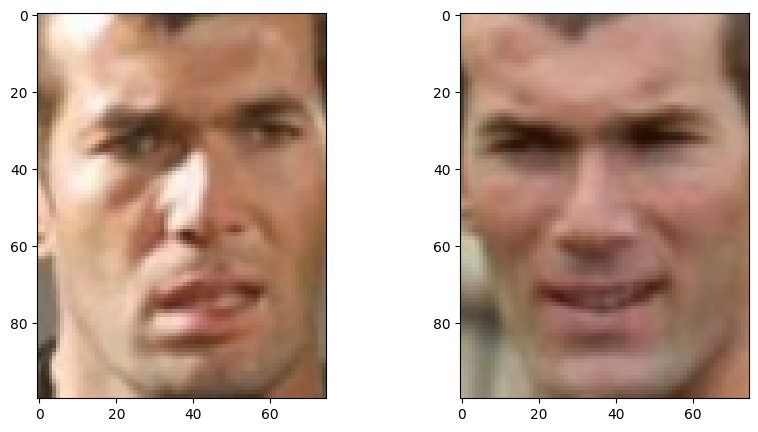

In [4]:
# You can play around with the target index to see different pairs
target = 1099
print(lfw_pairs_train.target[target]) # 0 for different people, 1 for same people

img1 = lfw_pairs_train.pairs[target, 0]
img2 = lfw_pairs_train.pairs[target, 1]
img1 = (img1 * 255).astype(np.uint8)
img2 = (img2 * 255).astype(np.uint8)
im1 = Image.fromarray(img1)
im2 = Image.fromarray(img2)

# show example pair of images from dataset
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.subplot(1, 2, 2)
plt.imshow(im2)
plt.show()

Number of pairs: 2200
torch.Size([3, 128, 128])


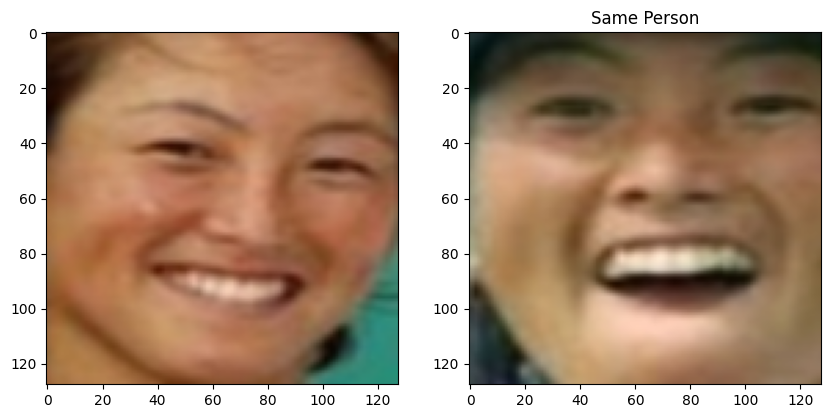

In [5]:
# Create Siamese Dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

batch_size = 32

# DataLoader
train_dataset_siamese = LFWSiameseDataset(lfw_pairs_train, transform=transform)
test_dataset_siamese = LFWSiameseDataset(lfw_pairs_test, transform=transform)
dataloader_siamese = DataLoader(train_dataset_siamese, batch_size=batch_size, shuffle=True)
test_loader_siamese = DataLoader(test_dataset_siamese, batch_size=1, shuffle=False)

print(f'Number of pairs: {len(train_dataset_siamese)}')

# this is just an example of what the output of the dataloader will look like
data_iterator = iter(dataloader_siamese)
img1_batch, img2_batch, label_batch = next(data_iterator)

img1 = img1_batch[0]
img2 = img2_batch[0]
label = label_batch[0]

print(img1.size())

to_PIL = transforms.ToPILImage()

img1 = to_PIL(img1)
img2 = to_PIL(img2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.subplot(1, 2, 2)
if label == 1:
    plt.title('Same Person')
else:
    plt.title('Different Person')
plt.imshow(img2)
plt.show()

### Implement Siamese Network Using ResNet-18

Here we take a pretrained ResNet-18 model, take off the classification head on the last layer, and include an embedding layer. In the forward function, we take as input two images, and put them each through the original ResNet-18 forward function.

In [6]:
from torchvision.models import ResNet18_Weights
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        modules = list(backbone.children())[:-1]  # remove classification head
        self.backbone = nn.Sequential(*modules)
        self.embedding_dim = backbone.fc.in_features

    def forward_one(self, x):
        # Run the image through the resnet-18 model
        x = self.backbone(x)
        return x.view(x.size(0), -1)

    def forward(self, x1, x2):
        emb1 = self.forward_one(x1)
        emb2 = self.forward_one(x2)
        return emb1, emb2


### Exercise 1: Implement Contrastive Loss

Follow Equation 16.10 on page 556 (section 16.2.4.1) to implement Contrastive Loss that is compatible with your Siamese Network. You can experiment with the margin parameter to see how it affects the results, you can start by using 1.0 as your default value. You should use the normalized Euclidean distance (Equation 16.7) discussed at the beginning of section 16.2.2 (pg. 554):

![normalized_distance](https://raw.githubusercontent.com/wingated/cs473/main/labs/images/lab_week_8_normalized_distance.png)

where $e$ is the embedding from the Siamese Network and $\hat{e} = e/||e||_2^2$

![contrastive_loss](https://raw.githubusercontent.com/wingated/cs473/main/labs/images/lab_week_8_contrastive_loss.png)

In [7]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, emb1, emb2, label):
        # Normalize embeddings
        emb1_norm = emb1 / emb1.norm(p=2, dim=1, keepdim=True)
        emb2_norm = emb2 / emb2.norm(p=2, dim=1, keepdim=True)

        # Compute pairwise Euclidean distance
        distances = torch.norm(emb1_norm - emb2_norm, p=2, dim=1)

        # Contrastive Loss:
        # L = (label) * d^2 + (1 - label) * max(0, margin - d)^2
        loss_same = label * distances.pow(2)
        loss_diff = (1 - label) * torch.clamp(self.margin - distances, min=0).pow(2)
        loss = torch.mean(loss_same + loss_diff)

        return loss


### Training

Below is a simple training setup that should work with the dataloader defined above and your Siamese Network. Feel free to improve the training process in any way you see fit and see how it affects the results. After training, it should be saved in your colab directory. To avoid retraining, I'd advise you to download these weights since colab won't save them after the runtime disconnects.

In [8]:
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for img1, img2, label in dataloader_siamese:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        optimizer.zero_grad()
        emb1, emb2 = model(img1, img2)
        loss = criterion(emb1, emb2, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * img1.size(0)
    avg_loss = running_loss / len(dataloader_siamese.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


torch.save(model.state_dict(), "siamese_resnet18_lfw.pth")

Epoch 1/10, Loss: 0.2709
Epoch 2/10, Loss: 0.1441
Epoch 3/10, Loss: 0.0953
Epoch 4/10, Loss: 0.0624
Epoch 5/10, Loss: 0.0472
Epoch 6/10, Loss: 0.0365
Epoch 7/10, Loss: 0.0276
Epoch 8/10, Loss: 0.0218
Epoch 9/10, Loss: 0.0198
Epoch 10/10, Loss: 0.0178


## Implementing Triplet Network

### Triplet Dataset

Because of how triplet loss takes in data, you'll need a different dataset class and dataloader to use in your Triplet Network. This dataset will return an anchor image, as well as a positive pair and a negative pair to be used in triplet loss.

In [9]:
class LFWTripletDataset(Dataset):
    """
    Dataset class for generating triplets (anchor, positive, negative)
    from the LFW pairs dataset for use in training with triplet loss.
    The anchor and positive are from the same identity, and the negative
    is from a different identity.
    """
    def __init__(self, lfw_pairs, transform=None):
        """
        :param lfw_pairs: sklearn.utils.Bunch, from fetch_lfw_pairs
        :param transform: torchvision or custom transform function
        """
        self.pairs = lfw_pairs.pairs    # shape: (N, 2, H, W)
        self.labels = lfw_pairs.target  # shape: (N,)
        self.transform = transform

        # Build a lookup for positive and negative indices
        self.same_indices = [i for i, y in enumerate(self.labels) if y == 1]
        self.diff_indices = [i for i, y in enumerate(self.labels) if y == 0]

    def __len__(self):
        # Return the number of same (positive) pairs = #triplets possible
        return len(self.same_indices)

    def __getitem__(self, idx):
        # Use a positive pair (same identity) as anchor/positive
        pos_pair_idx = self.same_indices[idx]
        anchor = self.pairs[pos_pair_idx, 0] # shape (H, W)
        positive = self.pairs[pos_pair_idx, 1]

        # Sample a negative example (one of the negative pairs: different identity)
        # Pick one randomly, and select one of its two images as negative
        neg_pair_idx = np.random.choice(self.diff_indices)
        # Pick one side of the negative pair randomly
        neg_side = np.random.choice([0, 1])
        negative = self.pairs[neg_pair_idx, neg_side]

        # Convert to PIL Images for transforms
        anchor = (anchor * 255).astype(np.uint8)
        positive = (positive * 255).astype(np.uint8)
        negative = (negative * 255).astype(np.uint8)

        anchor_img = Image.fromarray(anchor)
        positive_img = Image.fromarray(positive)
        negative_img = Image.fromarray(negative)

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
        else:
            anchor_img = transforms.ToTensor()(anchor_img)
            positive_img = transforms.ToTensor()(positive_img)
            negative_img = transforms.ToTensor()(negative_img)

        return anchor_img, positive_img, negative_img


Number of triplets: 1100
torch.Size([3, 128, 128])


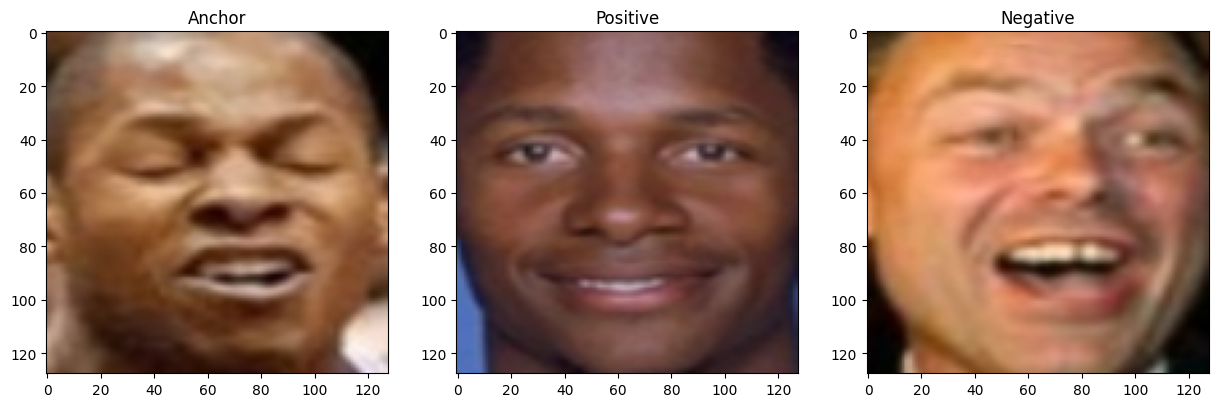

In [10]:
# Create Triplet Dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

batch_size = 32

# DataLoader
train_dataset_triplet = LFWTripletDataset(lfw_pairs_train, transform=transform)
test_dataset_triplet = LFWTripletDataset(lfw_pairs_test, transform=transform)
dataloader_triplet = DataLoader(train_dataset_triplet, batch_size=batch_size, shuffle=True)
test_loader_triplet = DataLoader(test_dataset_triplet, batch_size=1, shuffle=False)

print(f'Number of triplets: {len(train_dataset_triplet)}')

# this is just an example of what the output of the dataloader will look like

data_iterator = iter(dataloader_triplet)
anchor_batch, positive_batch, negative_batch = next(data_iterator)

anchor = anchor_batch[0]
positive = positive_batch[0]
negative = negative_batch[0]
print(anchor.size())

anchor = to_PIL(anchor)
positive = to_PIL(positive)
negative = to_PIL(negative)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(anchor)
plt.title('Anchor')
plt.subplot(1, 3, 2)
plt.imshow(positive)
plt.title('Positive')
plt.subplot(1, 3, 3)
plt.imshow(negative)
plt.title('Negative')
plt.show()

### Exercise 2: Implement Triplet Network using ResNet18

Following a similar structure to the Siamese Network above, implement a simple Triplet Network class that will take as input an anchor image, a positive and negative example relative to the anchor, and return embeddings for each (it should be very similar to the Siamese Network implementation).

In [11]:
class TripletNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pretrained ResNet-18
        backbone = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        modules = list(backbone.children())[:-1]  # remove final classification head
        self.backbone = nn.Sequential(*modules)
        self.embedding_dim = backbone.fc.in_features

    def forward_one(self, x):
        # Forward pass for a single image
        x = self.backbone(x)
        return x.view(x.size(0), -1)  # flatten

    def forward(self, anchor, positive, negative):
        # Forward pass for a triplet
        emb_anchor = self.forward_one(anchor)
        emb_positive = self.forward_one(positive)
        emb_negative = self.forward_one(negative)
        return emb_anchor, emb_positive, emb_negative

### Exercise 3: Implement Triplet Loss

Follow Equation 16.10 on page 556 (section 16.2.4.2) to implement Triplet Loss that is compatible with your Triplet Network. Again, you can experiment with the margin parameter to see how it affects the results, the default is 1.0. Use the same distance as in the Contrastive Loss.

![triplet_loss](https://raw.githubusercontent.com/wingated/cs473/main/labs/images/lab_week_8_triplet_loss.png)

In [12]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, anchor_emb, positive_emb, negative_emb):
        # Normalize embeddings
        anchor_norm = anchor_emb / anchor_emb.norm(p=2, dim=1, keepdim=True)
        positive_norm = positive_emb / positive_emb.norm(p=2, dim=1, keepdim=True)
        negative_norm = negative_emb / negative_emb.norm(p=2, dim=1, keepdim=True)

        # Compute squared distances
        pos_dist = torch.norm(anchor_norm - positive_norm, p=2, dim=1).pow(2)
        neg_dist = torch.norm(anchor_norm - negative_norm, p=2, dim=1).pow(2)

        # Triplet loss formula
        loss = torch.clamp(pos_dist - neg_dist + self.margin, min=0.0)
        return loss.mean()


### Training

In [13]:
model = TripletNetwork().to(device)
criterion = TripletLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10
# Training loop for TripletNetwork
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for anchor, positive, negative in dataloader_triplet:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()
        anchor_emb, positive_emb, negative_emb = model(anchor, positive, negative)
        loss = criterion(anchor_emb, positive_emb, negative_emb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * anchor.size(0)
    avg_loss = running_loss / len(dataloader_triplet.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Triplet Loss: {avg_loss:.4f}")

# Save triplet network weights
torch.save(model.state_dict(), "triplet_resnet18_lfw.pth")


Epoch 1/10, Triplet Loss: 0.8148
Epoch 2/10, Triplet Loss: 0.4915
Epoch 3/10, Triplet Loss: 0.3277
Epoch 4/10, Triplet Loss: 0.2484
Epoch 5/10, Triplet Loss: 0.1898
Epoch 6/10, Triplet Loss: 0.1668
Epoch 7/10, Triplet Loss: 0.1425
Epoch 8/10, Triplet Loss: 0.1297
Epoch 9/10, Triplet Loss: 0.1182
Epoch 10/10, Triplet Loss: 0.1072


### Exercise 4: Evaluations

For this section, you'll have some freedom in your implementation. The task is to come up with a way to evaluate how well each of your networks does. You'll most likely want to include results comparing your Siamese Network, your Triplet Network, and a base ResNet18 model. The way in which you evaluate it is up to you, but you should think hard about what the purpose of these networks is (what are they trying to optimize) and how you can measure that.

Below is an example of what comparing the embedding distances might look like between the base ResNet18 model and one of your models (Note: a graph like this wouldn't be sufficient for credit, it is intended to show you what kind of direction you might take this).

Make sure to include some clearly labeled graphs, as well as some analysis of what you did for your evaluations and what the results were.

![siamese_dist](https://raw.githubusercontent.com/wingated/cs473/main/labs/images/lab_week_8_siamese_dist.png)

![resnet18_dist](https://raw.githubusercontent.com/wingated/cs473/main/labs/images/lab_week_8_resnet18_dist.png)

In [14]:
import torchvision
# base resnet model to compare against
class ResNet18Embed(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # remove FC layer

    def forward(self, x):
        with torch.no_grad():
            x = self.feature_extractor(x)
            x = x.view(x.size(0), -1)
        return x

In [15]:
def evaluate_models(models, model_names, loader, threshold=0.7):
    """
    Evaluate and compare multiple embedding models on pairwise distances.

    models: list of PyTorch models
    model_names: list of strings (names)
    loader: DataLoader that yields (img1, img2, label)
    threshold: distance threshold for predicting "same" vs "different"
    """
    for model, name in zip(models, model_names):
        print(f"\nEvaluating {name}...")
        model.eval()
        dists_same, dists_diff = [], []
        correct, total = 0, 0

        with torch.no_grad():
            for img1, img2, label in loader:
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)

                # Forward pass depending on model
                if "triplet" in name.lower():
                    emb_anchor, emb_pos, _ = model(img1, img2, img2)  # dummy negative
                    emb1, emb2 = emb_anchor, emb_pos
                elif "base" in name.lower():
                    emb1 = model(img1)
                    emb2 = model(img2)
                else:  # Siamese network
                    emb1, emb2 = model(img1, img2)

                # Normalize embeddings
                emb1 = emb1 / emb1.norm(p=2, dim=1, keepdim=True)
                emb2 = emb2 / emb2.norm(p=2, dim=1, keepdim=True)

                # Compute distance
                dist = torch.norm(emb1 - emb2, dim=1)

                # Collect distances for histograms
                dists_same.extend(dist[label==1].cpu().numpy())
                dists_diff.extend(dist[label==0].cpu().numpy())

                # Accuracy based on threshold
                pred = (dist < threshold).float()
                correct += (pred == label).sum().item()
                total += label.size(0)

        # Accuracy
        acc = correct / total
        print(f"Accuracy (threshold={threshold}): {acc*100:.2f}%")

        # Plot histograms
        plt.figure(figsize=(6,4))
        plt.hist(dists_same, bins=30, alpha=0.7, label='Same Person')
        plt.hist(dists_diff, bins=30, alpha=0.7, label='Different Person')
        plt.title(f"{name} Embedding Distances")
        plt.xlabel("Normalized Euclidean Distance")
        plt.ylabel("Count")
        plt.legend()
        plt.show()



Evaluating Base ResNet18...
Accuracy (threshold=0.7): 60.70%


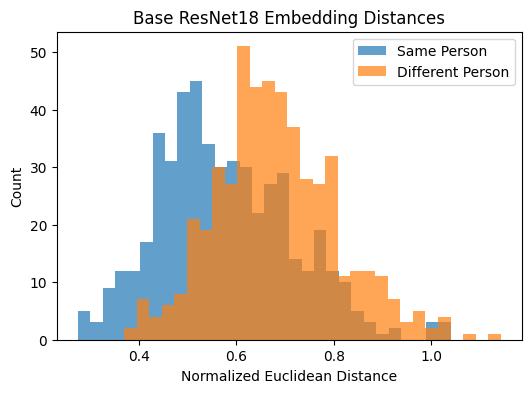


Evaluating Siamese Network...
Accuracy (threshold=0.7): 73.20%


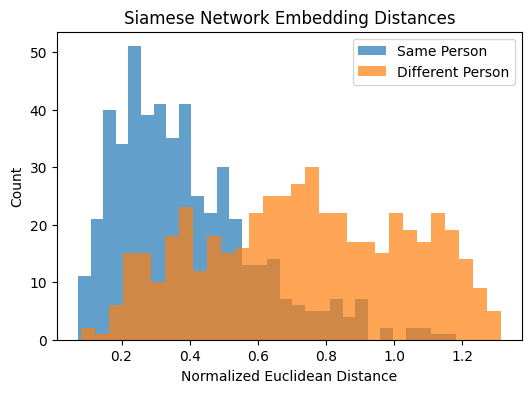


Evaluating Triplet Network...
Accuracy (threshold=0.7): 65.20%


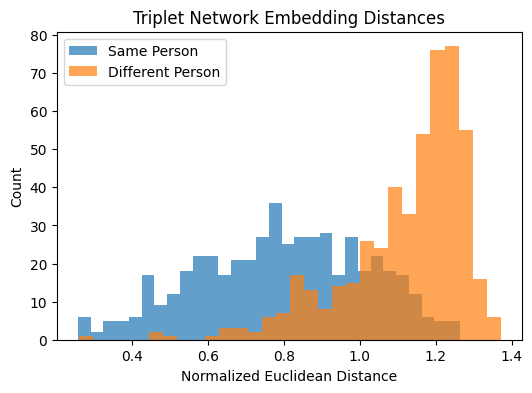

In [16]:
base_resnet = ResNet18Embed().to(device)
siamese_net = SiameseNetwork().to(device)
siamese_net.load_state_dict(torch.load('siamese_resnet18_lfw.pth'))  # path as saved above
triplet_net = TripletNetwork().to(device)
triplet_net.load_state_dict(torch.load('triplet_resnet18_lfw.pth'))  # path as saved above

# Make sure to put the model in evaluation mode
base_resnet.eval()
siamese_net.eval()
triplet_net.eval()

models = [base_resnet, siamese_net, triplet_net]
names = ["Base ResNet18", "Siamese Network", "Triplet Network"]

evaluate_models(models, names, test_loader_siamese, threshold=0.7)

### Analysis:

(your analysis here)